<a href="https://colab.research.google.com/github/ElzatAhmed/machine-learning-notes/blob/main/deep_reinforcement_learning_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 导入工具包
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 从google drive中读取上传的文件
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# 读取csv文件
whole = pd.read_csv('/content/gdrive/MyDrive/composite-index-per-month.csv')
whole.head()

,日期,收盘,开盘,高,低,交易量,涨跌幅
0,2022年4月,"3,282.72","3,234.67","3,287.23","3,226.30",37.82B,0.94%
1,2022年3月,"3,252.20","3,471.36","3,500.29","3,023.30",870.20B,-6.07%
2,2022年2月,"3,462.31","3,407.76","3,500.15","3,390.46",537.73B,3.00%
3,2022年1月,"3,361.44","3,649.15","3,651.89","3,356.56",662.57B,-7.65%
4,2021年12月,"3,639.78","3,561.89","3,708.94","3,558.69",863.87B,2.13%


In [4]:
# 将csv文件倒置
reversed = whole.iloc[::-1]
reversed.reset_index(inplace=True)
reversed.head()

,index,日期,收盘,开盘,高,低,交易量,涨跌幅
0,327,1995年1月,562.59,637.73,657.45,547.39,502.63M,-13.16%
1,326,1995年2月,549.26,559.78,608.25,524.43,648.18M,-2.37%
2,325,1995年3月,646.91,548.91,647.77,545.74,2.42B,17.78%
3,324,1995年4月,579.93,650.98,680.73,548.75,3.77B,-10.35%
4,323,1995年5月,700.51,577.95,926.41,564.86,5.84B,20.79%


In [10]:
# 只取出csv文件'收盘'一列
annual_data = reversed.loc[:, ['收盘']]
annual_data.head()

,收盘
0,562.59
1,549.26
2,646.91
3,579.93
4,700.51


In [187]:
# 按季度计算平均收盘价格
season_data = []
count = 0
datas = []
for data in annual_data['收盘']:
  if count == 2:
    season_data.append(np.mean(datas))
    datas.clear()
    count = 0
  else:
    datas.append(float(data.replace(',', '')))
    count += 1
if len(datas) > 0:
  season_data.append(np.mean(datas))

In [189]:
# 制季度作dataframe展示
season_dict = {}
season = 1
year = 1995
for data in season_data:
  if season > 4:
    year += 1
    season = 1
  season_dict[f'{year}年第{season}季度'] = data
  season += 1
temp = pd.DataFrame(season_dict, index=[0])

In [190]:
temp.head()

,1995年第1季度,1995年第2季度,1995年第3季度,1995年第4季度,1996年第1季度,1996年第2季度,1996年第3季度,1996年第4季度,1997年第1季度,1997年第2季度,...,2020年第1季度,2020年第2季度,2020年第3季度,2020年第4季度,2021年第1季度,2021年第2季度,2021年第3季度,2021年第4季度,2022年第1季度,2022年第2季度
0,555.925,640.22,709.71,679.22,545.14,662.405,816.21,1004.83,1002.505,1339.465,...,2928.415,2856.215,3352.845,3308.145,3496.075,3531.17,3470.65,3555.615,3411.875,3282.72


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

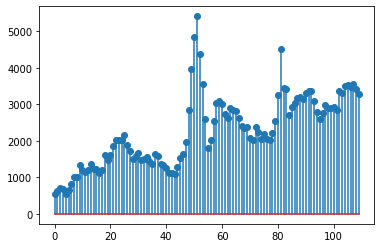

In [191]:
# 季度收盘价波动图
plt.stem([i for i in range(len(season_data))], season_data)

In [192]:
# 将数据转为tensor
x = torch.tensor([[i] for i in range(len(season_data))], dtype=torch.float32)
y = torch.tensor([[data] for data in season_data], dtype=torch.float32)

In [193]:
print(x.shape)
print(y.shape)

torch.Size([110, 1])
torch.Size([110, 1])


In [194]:
# 定义模型
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.lin1 = nn.Linear(1, 64)
    self.lin2 = nn.Linear(64, 128)
    self.lin3 = nn.Linear(128, 64)
    self.out = nn.Linear(64, 1)
  
  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    x = F.relu(x)
    x = self.lin3(x)
    x = F.relu(x)
    return self.out(x)

In [208]:
# 训练函数
log_interval = 2000
def train(epoch, model, loss_func, optimizer):
  model.train()
  optimizer.zero_grad()
  pred = model(x)
  loss = loss_func(pred, y)
  loss.backward()
  optimizer.step()
  if (epoch + 1) % log_interval == 0:
    print(f'epoch {epoch + 1}: loss = {loss}')

In [218]:
# 实例化模型
network = Net()
network

Net(
  (lin1): Linear(in_features=1, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [219]:
# 损失函数与optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [220]:
# 训练
n_epochs = 20000
for epoch in range(n_epochs):
  train(epoch, network, loss_func, optimizer)

epoch 2000: loss = 407846.96875
epoch 4000: loss = 407310.84375
epoch 6000: loss = 56368.078125
epoch 8000: loss = 59794.88671875
epoch 10000: loss = 42252.66796875
epoch 12000: loss = 35891.60546875
epoch 14000: loss = 61969.28515625
epoch 16000: loss = 23297.064453125
epoch 18000: loss = 31328.00390625
epoch 20000: loss = 14624.6591796875


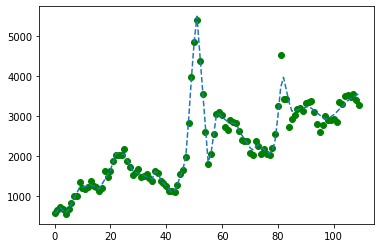

In [221]:
# 比较模型画的图和实际散点图
network.eval()
y_pred = network(x)
plt.plot(x, y, 'go')
plt.plot(x, y_pred.detach().numpy(), '--')

In [225]:
# 预测2022年第二季度末的数据
network(torch.tensor([109], dtype=torch.float32))

tensor([3560.5579], grad_fn=<AddBackward0>)